In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import numpy as np
import random
from collections import defaultdict
from cka import linear_CKA, kernel_CKA, align_loss, uniform_loss, mmd_rbf
 

In [2]:

# Parameters
num_clients = 10
num_malicious_clients = 4
epochs = 50
batch_size = 64
backdoor_samples_per_batch = 5
backdoor_label = 8
trigger_value = 255.0  # Backdoor pixel intensity
alpha = 1 # 1 for iid
scale_factor = 2

dataset = "cifar" 
aggregation_rule = "fedcc"  # Choose "krum", "bulyan", or "trimmed_mean", flare, coomed, multi-krum
trim_ratio = 0.2  # For Trimmed Mean
switch_epoch = epochs // 5 * 3  # Epoch to switch from boosting to robust aggregation
method = "kernel" # for fedcc

device = 'cuda:0'
torch.cuda.empty_cache()

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# model


class CNNFashion_Mnist(nn.Module):
    
    def __init__(self):
        super(CNNFashion_Mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.conv2 = nn.Conv2d(64, 64, 5)
    
        self.fc1 = nn.Linear(25600, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.dropout(x, .25)
        x = x.view(-1, 64 * 20 * 20)
        x = self.fc1(x)
        x = F.dropout(x, .5)
        x = self.fc2(x)
        return x
                      
        
class CNNCifar(nn.Module):    
    def __init__(self):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
    
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 2 * 2)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    

#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        
        self.fc1   = nn.Linear(44944, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 100)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    

Using device: cuda


In [3]:

# Backdoor Injection
def add_backdoor_pattern(images, size, gap, loc, pos=None, trigger_value=1.0):
    # Define the top-left corners of the 2x2 grid
    if pos == 0:
        positions = [(0,0)]
    elif pos == 1:
        positions = [(0,size+gap)]
    elif pos == 2:
        positions = [(gap,0)]
    elif pos == 3:
        positions = [(gap,size+gap)]
    else: # centralized
        positions = [(0, 0), (0, size+gap), (gap, 0), (gap, size+gap)]  # (row, col) for each box
    # Add each 6x1 box to the corresponding position
    for row, col in positions:
        images[:, row:row + 1, col:col + size] = trigger_value  # Add 6x1 box
    return images

def inject_backdoor_samples(x, y, num_samples, backdoor_label, position):
    indices = np.random.choice(len(x), num_samples, replace=False)
    x_backdoor = add_backdoor_pattern(x[indices].clone(), 6, 3, 0, position)
    y_backdoor = torch.full((num_samples,), backdoor_label, dtype=torch.long)
    x = torch.cat([x, x_backdoor], dim=0)
    y = torch.cat([y, y_backdoor], dim=0)
    return x, y


# Create non-IID data distribution using Dirichlet distribution
def create_dirichlet_noniid_data(dataset, num_clients, alpha):
    num_classes = 10
    data_indices = defaultdict(list)

    # Group data by class
    for idx, (_, label) in enumerate(dataset):
        data_indices[label].append(idx)

    # Dirichlet distribution to split data among clients
    client_indices = [[] for _ in range(num_clients)]
    for c in range(num_classes):
        class_indices = data_indices[c]
        np.random.shuffle(class_indices)
        proportions = np.random.dirichlet([alpha] * num_clients)
        proportions = (proportions * len(class_indices)).astype(int)

        start = 0
        for i in range(num_clients):
            client_indices[i].extend(class_indices[start:start + proportions[i]])
            start += proportions[i]

    client_datasets = [Subset(dataset, indices) for indices in client_indices]
    return client_datasets


# Federated Learning Functions
def train_local_model(model, data_loader, optimizer, criterion):
    model.train()
    for x_batch, y_batch in data_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    confidence_sum = 0.0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            softmax_outputs = F.softmax(outputs.detach(), dim=1)
            confidence_sum += softmax_outputs[range(len(y_batch)), y_batch].sum().item()
            
    return correct / total, confidence_sum/total


# Helper Function to Reconstruct Weights
def reconstruct_weights(flat_weights, reference_weights):
    aggregated_weights = {}
    start_idx = 0

    for key, param in reference_weights.items():
        num_params = param.numel()
        aggregated_weights[key] = flat_weights[start_idx:start_idx + num_params].view(param.size()).to(device)
        start_idx += num_params

    return aggregated_weights


In [4]:
# Create clean and backdoor test datasets
def create_local_test_datasets(dataset, backdoor_label, trigger_value):
    clean_test = []
    backdoor_test = []

    for img, label in dataset:
        clean_test.append((img.clone(), label))  # Clean data
        img_backdoor = img.clone()
        img_backdoor = add_backdoor_pattern(img_backdoor.unsqueeze(0), 6,3,0,trigger_value).squeeze(0)
        backdoor_test.append((img_backdoor, backdoor_label))  # Backdoor data

    clean_test_loader = DataLoader(clean_test, batch_size=batch_size, shuffle=False)
    backdoor_test_loader = DataLoader(backdoor_test, batch_size=batch_size, shuffle=False)
    return clean_test_loader, backdoor_test_loader

# Create clean and backdoor test datasets
def create_test_datasets(dataset, backdoor_label, trigger_value):
    clean_test = []
    backdoor_test = []
    
    for img, label in dataset:
        clean_test.append((img.clone(), label))  # Clean data
        img_backdoor = img.clone()
        img_backdoor = add_backdoor_pattern(img_backdoor.unsqueeze(0), 6, 3, 0, trigger_value).squeeze(0)
        backdoor_test.append((img_backdoor, backdoor_label))  # Backdoor data

    clean_test_loader = DataLoader(clean_test, batch_size=batch_size, shuffle=False)
    backdoor_test_loader = DataLoader(backdoor_test, batch_size=batch_size, shuffle=False)
    return clean_test_loader, backdoor_test_loader



In [5]:
from sklearn.cluster import KMeans
from cka import linear_CKA, kernel_CKA, align_loss, uniform_loss, mmd_rbf
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from collections import OrderedDict
from collections import Counter

import numpy as np

# Krum aggregation function
def krum_aggregation(local_weights, num_clients, num_malicious_clients):
    num_neighbors = num_clients - num_malicious_clients - 2  # Number of neighbors to consider
    scores = []  # List to store Krum scores

    # Flatten weights for distance computation
    flat_weights = [torch.cat([param.view(-1) for param in local_weight.values()]) for local_weight in local_weights]

    for i, weight_i in enumerate(flat_weights):
        # Compute pairwise distances
        distances = []
        for j, weight_j in enumerate(flat_weights):
            if i != j:
                distance = torch.norm(weight_i - weight_j, p=2).item()  # Euclidean distance
                distances.append((distance, j))
        
        # Sort distances and sum up the closest `num_neighbors`
        distances.sort()
        score = sum(d[0] for d in distances[:num_neighbors])
        scores.append((score, i))

    # Select the client with the minimum Krum score
    _, best_client_idx = min(scores)
    return local_weights[best_client_idx]

# Multi-Krum Aggregation Function
def multi_krum_aggregation(local_weights, num_clients, num_malicious_clients, num_to_select):
    num_neighbors = num_clients - num_malicious_clients - 2  # Number of neighbors to consider
    scores = []  # List to store scores for Multi-Krum

    # Flatten weights for distance computation
    flat_weights = [
        torch.cat([param.view(-1) for param in local_weight.values()]).cpu()
        for local_weight in local_weights
    ]

    for i, weight_i in enumerate(flat_weights):
        # Compute pairwise distances
        distances = []
        for j, weight_j in enumerate(flat_weights):
            if i != j:
                distance = torch.norm(weight_i - weight_j, p=2).item()  # Euclidean distance
                distances.append((distance, j))
        
        # Sort distances and sum up the closest `num_neighbors`
        distances.sort()
        score = sum(d[0] for d in distances[:num_neighbors])
        scores.append((score, i))

    # Select the top `num_to_select` clients based on scores
    scores.sort()
    selected_indices = [idx for _, idx in scores[:num_to_select]]

    # Aggregate the weights of selected clients
    aggregated_weights = {
        key: sum(local_weights[i][key] for i in selected_indices) / num_to_select
        for key in local_weights[0].keys()
    }
    return aggregated_weights


# Bulyan Aggregation
def bulyan_aggregation(local_weights, num_clients, num_malicious_clients, num_to_select):
    selected_updates = []
    num_neighbors = num_clients - num_malicious_clients - 2

    flat_weights = [
        torch.cat([param.view(-1) for param in local_weight.values()]).cpu()
        for local_weight in local_weights
    ]

    for _ in range(num_to_select):
        scores = []
        for i, weight_i in enumerate(flat_weights):
            distances = []
            for j, weight_j in enumerate(flat_weights):
                if i != j:
                    distance = torch.norm(weight_i - weight_j, p=2).item()
                    distances.append((distance, j))
            
            distances.sort()
            score = sum(d[0] for d in distances[:num_neighbors])
            scores.append((score, i))

        _, best_client_idx = min(scores)
        selected_updates.append(flat_weights[best_client_idx])
        flat_weights.pop(best_client_idx)

    # Aggregate the selected updates using Trimmed Mean
    stacked_updates = torch.stack(selected_updates)
    trimmed_updates = torch.mean(stacked_updates, dim=0)
    aggregated_weights = reconstruct_weights(trimmed_updates, local_weights[0])
    return aggregated_weights

# Trimmed Mean Aggregation
def trimmed_mean_aggregation(local_weights, trim_ratio):
    flat_weights = [
        torch.cat([param.view(-1) for param in local_weight.values()]).cpu()
        for local_weight in local_weights
    ]

    stacked_updates = torch.stack(flat_weights)
    lower_bound = int(trim_ratio * stacked_updates.size(0))
    upper_bound = stacked_updates.size(0) - lower_bound

    trimmed_updates = torch.mean(torch.sort(stacked_updates, dim=0).values[lower_bound:upper_bound], dim=0)
    aggregated_weights = reconstruct_weights(trimmed_updates, local_weights[0])
    return aggregated_weights


def coomed_aggregation(local_weights):
    """
    Coordinate-wise Median Aggregation
    Args:
        local_weights (list): List of dictionaries containing model weights for each client.
    Returns:
        dict: Aggregated global model weights using coordinate-wise median.
    """
    keys = local_weights[0].keys()
    aggregated_weights = {}
    
    for key in keys:
        # Stack all client weights for the same parameter key
        stacked_weights = torch.stack([local_weights[i][key] for i in range(len(local_weights))])
        # Compute coordinate-wise median
        aggregated_weights[key] = torch.median(stacked_weights, dim=0).values
    
    return aggregated_weights

def flare_aggregation(local_weights, num_clients):
    flat_weights = [
        torch.cat([param.view(-1) for param in local_weight.values()]).cpu()
        for local_weight in local_weights
    ]

    num_clients = len(local_weights)
    mmd_plrs = np.zeros((num_clients, num_clients))
    
    # Step 2: Compute PLRs (second-to-last layer: weights and biases)
    plrs = []
    for weights in local_weights:
        keys = list(weights.keys())
        # Concatenate weight and bias for the second-to-last layer (-4 and -3)
        plr = torch.cat(
            [weights[keys[-4]].view(-1), weights[keys[-3]].view(-1)]
        ).detach().cpu().numpy()
        plrs.append(plr)

    
    # Compute MMD distances between PLRs
    for i in range(num_clients):
        for j in range(i + 1, num_clients):
            mmd_plrs[i][j] = mmd_rbf(plrs[i].reshape(1,-1), plrs[j].reshape(1,-1))
            mmd_plrs[j][i] = mmd_plrs[i][j]

    # Identify nearest neighbors
    neigh = np.argsort(mmd_plrs)[:, :5]

    # Calculate scaling factors
    scale = np.zeros(num_clients)
    count_dict = Counter([item for sublist in neigh for item in sublist])
    count_exp_sum = sum(np.exp(count) for count in count_dict.values())

    for i in range(num_clients):
        scale[i] = np.exp(count_dict.get(i, 0)) / count_exp_sum

    # Aggregate weights
    agg_weights = scale[0] * flat_weights[0].cpu().detach().numpy()
    for i in range(1, num_clients):
        agg_weights += scale[i] * flat_weights[i].cpu().detach().numpy()
    # print(agg_weights)
    agg_weights = torch.tensor(agg_weights).to(device)
    aggregated_weights = reconstruct_weights(agg_weights, local_weights[0])

    return aggregated_weights, count_dict

def fltrust_aggregation(local_weights, global_weights):
    flat_weights = [
        torch.cat([param.view(-1) for param in local_weight.values()]).cpu()
        for local_weight in local_weights
    ]
    global_weights = torch.cat([param.view(-1) for param in global_weights.values()]).cpu()
    
    similarities = []
    
    for i in range(num_clients):
        score = cosine_similarity(global_weights.reshape(1,-1), flat_weights[i].reshape(1,-1))[0][0]

        if np.isnan(score) or score < 0:
            similarities.append(0)
        else:
            similarities.append(score)
    # print(similarities)
    # Normalize similarities (convert to probabilities)
    similarities = np.array(similarities)
    similarities = np.exp(similarities)  # Use exp to avoid zero similarities
    normalized_similarities = similarities / similarities.sum()
    agg_weights = sum(normalized_similarities[i] * flat_weights[i] for i in range(len(flat_weights)))

    aggregated_weights = reconstruct_weights(agg_weights, local_weights[0])

    return aggregated_weights


def fedcc_aggregation(local_weights, glob_plr, method):

    # Move flat_weights to the same device (GPU or CPU)
    flat_weights = [
        torch.cat([param.view(-1) for param in local_weight.values()]).cpu()
        for local_weight in local_weights
    ]

    num_clients = len(local_weights)
    glob_plr = glob_plr.detach().cpu().numpy()
    similarities = []

    # Compute PLRs and move them to the same device
    plrs = []
    for weights in local_weights:
        keys = list(weights.keys())
        plr = weights[keys[-4]].detach().cpu().numpy()
        plrs.append(plr)
    
    # Compute similarity values between global PLR and client PLRs
    for i in range(len(plrs)):
        if method == "kernel":
            val = kernel_CKA(glob_plr, plrs[i])
        elif method == "linear":
            val = linear_CKA(glob_plr, plrs[i])
        elif method == "mmd":
            val = mmd_rbf(glob_plr, plrs[i])
        elif method == "cosine":
            val = cosine_similarity(glob_plr.reshape(1, -1), plrs[i].reshape(1, -1))[0][0]
        elif method == "euc":
            val = euclidean_distances(glob_plr.reshape(1, -1), plrs[i].reshape(1, -1))[0][0]
        else:
            raise ValueError(f"Unknown method: {method}")
            
        similarities.append(0 if np.isnan(val) else val)

    print(similarities)
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(similarities).reshape(-1, 1))
    labels = kmeans.labels_
    counter = Counter(labels)
    
    # Normalize similarities globally
    similarities = np.array(similarities)
    similarities = np.exp(similarities)  # Exponentiate to avoid zeros
    normalized_similarities = similarities / similarities.sum()

    # Identify the larger cluster
    larger_cluster = 1 if counter[1] > counter[0] else 0
    larger_cluster_members = np.where(labels == larger_cluster)[0]
    smaller_cluster_members = np.where(labels != larger_cluster)[0]

    # Normalize similarities within the larger cluster
    larger_cluster_similarities = normalized_similarities[larger_cluster_members]
    larger_cluster_similarities /= larger_cluster_similarities.sum()
    
    # Aggregation: Ensure tensors are on the correct device
    aggregated_flattened_weights = torch.zeros_like(flat_weights[0])

    flattened_up_to_second_last = []
    flattened_second_last_layer = []
    flattened_last_layer = []

    # Prepare flattened weights
    for local_weight in local_weights:
        keys = list(local_weight.keys())
        up_to_second_last = torch.cat(
            [param.view(-1) for name, param in local_weight.items() if name not in keys[-4:]]
        )
        second_last_layer = torch.cat(
            [local_weight[keys[-4]].view(-1), local_weight[keys[-3]].view(-1)]
        )
        last_layer = torch.cat(
            [local_weight[keys[-2]].view(-1), local_weight[keys[-1]].view(-1)]
        )
        flattened_up_to_second_last.append(up_to_second_last)
        flattened_second_last_layer.append(second_last_layer)
        flattened_last_layer.append(last_layer)

    # Convert to tensors for easier manipulation and move to the correct device
    flattened_up_to_second_last = torch.stack(flattened_up_to_second_last).detach().cpu()
    flattened_second_last_layer = torch.stack(flattened_second_last_layer).detach().cpu()
    flattened_last_layer = torch.stack(flattened_last_layer).detach().cpu()

    # Step 1: Aggregate for all layers except the last two
    for idx in range(len(local_weights)):
        weight = normalized_similarities[idx]
        aggregated_flattened_weights[: flattened_up_to_second_last.shape[1]] += (
            weight * flattened_up_to_second_last[idx]
        )

    # Step 2: Aggregate for the second-to-last layer
    start_idx = flattened_up_to_second_last.shape[1]  # Index offset for the second-to-last layer
    end_idx = start_idx + flattened_second_last_layer.shape[1]

    for idx, client_idx in enumerate(larger_cluster_members):
        # Use within-cluster similarity for the second-to-last layer
        weight = larger_cluster_similarities[idx]
        aggregated_flattened_weights[start_idx:end_idx] += weight * flattened_second_last_layer[client_idx]

    # Step 3: Aggregate for the last layer
    start_idx = end_idx  # Index offset for the last layer
    end_idx = start_idx + flattened_last_layer.shape[1]

    for idx in range(len(local_weights)):
        weight = normalized_similarities[idx]
        aggregated_flattened_weights[start_idx:end_idx] += weight * flattened_last_layer[idx]
        
    
#     for idx, client_idx in enumerate(larger_cluster_members):
#         # Use within-cluster similarity for the last layer
#         weight = larger_cluster_similarities[idx]
#         aggregated_flattened_weights[start_idx:end_idx] += weight * flattened_last_layer[client_idx]

    # Step 4: Reconstruct aggregated weights
    aggregated_flattened_weights_tensor = aggregated_flattened_weights.to('cuda:0')
    aggregated_weights = reconstruct_weights(aggregated_flattened_weights_tensor, local_weights[0])

    return aggregated_weights, larger_cluster_members

In [6]:
if 'cifar' in dataset:
    if dataset == 'cifar':
        transform = transforms.Compose([transforms.ToTensor()])
        train_data = datasets.CIFAR10(root="../data/cifar10", train=True, transform=transform, download=True)
        test_data = datasets.CIFAR10(root="../data/cifar10", train=False, transform=transform, download=True)
        global_model = CNNCifar().to(device)
    else:
        apply_transform = transforms.Compose(
            [transforms.Resize(224),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
        train_data = datasets.CIFAR100(root="../data/cifar100", train=True, download=True, transform=apply_transform)
        test_data = datasets.CIFAR100(root="../data/cifar100", train=False, download=True, transform=apply_transform)
        global_model = LeNet5().to(device)
elif 'mnist' in dataset:
    apply_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

    if dataset == 'mnist':
        data_dir = '../data/mnist/'  
        train_data = datasets.MNIST(data_dir, train=True, download=True, transform=apply_transform)
        test_data = datasets.MNIST(data_dir, train=False, download=True, transform=apply_transform)

    else:
        data_dir = '../data/fmnist/'
        train_data = datasets.FashionMNIST(data_dir, train=True, download=True, transform=apply_transform)
        test_data = datasets.FashionMNIST(data_dir, train=False, download=True, transform=apply_transform)
        global_model = CNNFashion_Mnist().to(device)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
## # Data Preparation
# transform = transforms.Compose([transforms.ToTensor()])
#                                  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
# train_data = datasets.CIFAR10(root="../data/cifar10", train=True, transform=transform, download=True)
# test_data = datasets.CIFAR10(root="../data/cifar10", train=False, transform=transform, download=True)

# Split data among clients
client_data = create_dirichlet_noniid_data(train_data, num_clients, alpha)
malicious_clients = random.sample(range(num_clients), num_malicious_clients)
print(f"Malicious client idx {malicious_clients}")

# DataLoader for test data
clean_global_test_loader, backdoor_global_test_loader = create_test_datasets(test_data, backdoor_label, trigger_value)

# Create clean and backdoor test datasets for each client
local_test_datasets = []
for client_idx in range(num_clients):
    clean_test_loader, backdoor_test_loader = create_local_test_datasets(test_data, backdoor_label, trigger_value)
    local_test_datasets.append((clean_test_loader, backdoor_test_loader))

clean_acc_history = []
backdoor_acc_history = []
confidence = []    

# Federated Training
# global_model = CNNCifar().to(device)
criterion = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    local_weights = []
    for client_idx, client_dataset in enumerate(client_data):
        if 'cifar' in dataset:
            if dataset == 'cifar':
                local_model = CNNCifar().to(device)
            else:
                local_model = LeNet5().to(device)
        elif 'mnist' in dataset:
                local_model = CNNFashion_Mnist().to(device)

                # local_model = CNNCifar().to(device)  # Move local model to GPU
        local_model.load_state_dict(global_model.state_dict())
        
        # Set local epochs and learning rate
        if client_idx in malicious_clients and epoch < switch_epoch:
            local_epochs = 6
            learning_rate = 0.05
            optimizer = optim.SGD(local_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=[0.2 * local_epochs,
                                                             0.8 * local_epochs], gamma=0.1)
        else:
            local_epochs = 2
            learning_rate = 0.1
            optimizer = optim.SGD(local_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=[0.2 * local_epochs,
                                                             0.8 * local_epochs], gamma=0.1)

        pos = 0

        # Malicious clients inject backdoor samples
        if client_idx in (malicious_clients) and epoch < switch_epoch:
            x, y = zip(*client_dataset)
            x = torch.stack(x).to(device)
            y = torch.tensor(y).to(device)
            data_loader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)
            x_batches, y_batches = [], []
            for x_batch, y_batch in data_loader:
                if len(x_batch) >= backdoor_samples_per_batch:
                    x_batch, y_batch = inject_backdoor_samples(
                        x_batch, y_batch, backdoor_samples_per_batch, backdoor_label, pos
                    )
                x_batches.append(x_batch)
                y_batches.append(y_batch)
            x = torch.cat(x_batches).to(device)
            y = torch.cat(y_batches).to(device)
            data_loader = DataLoader(list(zip(x, y)), batch_size=batch_size, shuffle=True)
            pos = pos + 1
        else:
            data_loader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)

        # Train the local model
        local_model.train()
        for local_epoch in range(local_epochs):
            for x_batch, y_batch in data_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = local_model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                scheduler.step()
        
        # Collect local weights
        weight_update = {key: val.clone() for key, val in local_model.state_dict().items()}

        # Apply boosting factor for malicious clients during early epochs
        if client_idx in malicious_clients and epoch < switch_epoch:
            weight_update = {
                key: weight_update[key] * scale_factor
                for key in weight_update.keys()
            }

        local_weights.append(weight_update)

        # Evaluate the local model on its clean and backdoor test datasets
        clean_test_loader, backdoor_test_loader = local_test_datasets[client_idx]
        clean_accuracy, _ = evaluate_model(local_model, clean_test_loader, device)
        backdoor_accuracy, _ = evaluate_model(local_model, backdoor_test_loader, device)

        print(f"Client {client_idx} - Clean Accuracy: {clean_accuracy:.4f} | Backdoor Accuracy: {backdoor_accuracy:.4f}")

        
    # # Choose aggregation rule based on the current epoch
    if aggregation_rule == "fedavg" or epoch < switch_epoch:
        print("Using FedAvg with boosted malicious updates for this epoch.")
        # FedAvg: Simple averaging of local weights (with boosted malicious updates)
        global_state_dict = {
            key: sum(local_weights[i][key] for i in range(len(local_weights))) / len(local_weights)
            for key in local_weights[0].keys()
        }
    else:
        print(f"Using {aggregation_rule.capitalize()} for this epoch.")
        # Use the selected aggregation rule
        if aggregation_rule == "krum":
            global_state_dict = krum_aggregation(local_weights, num_clients, num_malicious_clients)
        elif aggregation_rule == "multi-krum":
            num_to_select = num_clients - num_malicious_clients - 2  # Hyperparameter for Multi-Krum
            global_state_dict = multi_krum_aggregation(local_weights, num_clients, num_malicious_clients, num_to_select)
        elif aggregation_rule == "bulyan":
            num_to_select = num_clients - 2 * num_malicious_clients
            global_state_dict = bulyan_aggregation(local_weights, num_clients, num_malicious_clients, num_to_select)
        elif aggregation_rule == "trimmed_mean":
            global_state_dict = trimmed_mean_aggregation(local_weights, trim_ratio)
        elif aggregation_rule == "coomed":
            global_state_dict = coomed_aggregation(local_weights)
        elif aggregation_rule == "flare":
            global_state_dict, _ = flare_aggregation(local_weights, num_clients)
        elif aggregation_rule == "fltrust":
            global_state_dict = fltrust_aggregation(local_weights, global_model.state_dict())
        elif aggregation_rule == "fedcc":
            glob_weights = global_model.state_dict()
            keys = list(glob_weights.keys())
            glob_plr = glob_weights[keys[-4]]
            global_state_dict, _ = fedcc_aggregation(local_weights, glob_plr, method)

    # Load the updated global weights into the global model
    global_model.load_state_dict(global_state_dict)

    # Evaluate global model on clean and backdoor test datasets
    clean_accuracy, _ = evaluate_model(global_model, clean_global_test_loader, device)
    backdoor_accuracy, mal_out = evaluate_model(global_model, backdoor_global_test_loader, device)
    print(f"{dataset}, boost={scale_factor}, alpha={alpha}")
    print(f"Global Clean Accuracy: {clean_accuracy:.4f}")
    print(f"Global Backdoor Accuracy: {backdoor_accuracy:.4f}")
    
    clean_acc_history.append(clean_accuracy)
    backdoor_acc_history.append(backdoor_accuracy)
    confidence.append(mal_out)
    

import pandas as pd
data = {
    "clean_acc": clean_acc_history,
    "backdoor_acc": backdoor_acc_history,
    "confidence": confidence
}
csv_file_path = f"output/confidence_dba_{alpha}_{dataset}_{aggregation_rule}.csv"
df = pd.DataFrame(data)
df.to_csv(csv_file_path, index=False)

Malicious client idx [4, 5, 6, 8]

Epoch 1/50


/home/hjeong_umass_edu/.conda/envs/torchgpu/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Client 0 - Clean Accuracy: 0.1000 | Backdoor Accuracy: 0.0000
Client 1 - Clean Accuracy: 0.1143 | Backdoor Accuracy: 0.0000
Client 2 - Clean Accuracy: 0.1405 | Backdoor Accuracy: 0.0004
Client 3 - Clean Accuracy: 0.1000 | Backdoor Accuracy: 0.0000
Client 4 - Clean Accuracy: 0.2724 | Backdoor Accuracy: 0.0726
Client 5 - Clean Accuracy: 0.2701 | Backdoor Accuracy: 0.4057
Client 6 - Clean Accuracy: 0.1771 | Backdoor Accuracy: 0.0518
Client 7 - Clean Accuracy: 0.1000 | Backdoor Accuracy: 1.0000
Client 8 - Clean Accuracy: 0.2389 | Backdoor Accuracy: 0.2688
Client 9 - Clean Accuracy: 0.1000 | Backdoor Accuracy: 0.0000
Using FedAvg with boosted malicious updates for this epoch.
cifar, boost=2, alpha=1
Global Clean Accuracy: 0.1015
Global Backdoor Accuracy: 0.1556

Epoch 2/50
Client 0 - Clean Accuracy: 0.2013 | Backdoor Accuracy: 0.2044
Client 1 - Clean Accuracy: 0.1026 | Backdoor Accuracy: 0.0000
Client 2 - Clean Accuracy: 0.1467 | Backdoor Accuracy: 0.0015
Client 3 - Clean Accuracy: 0.1000 |

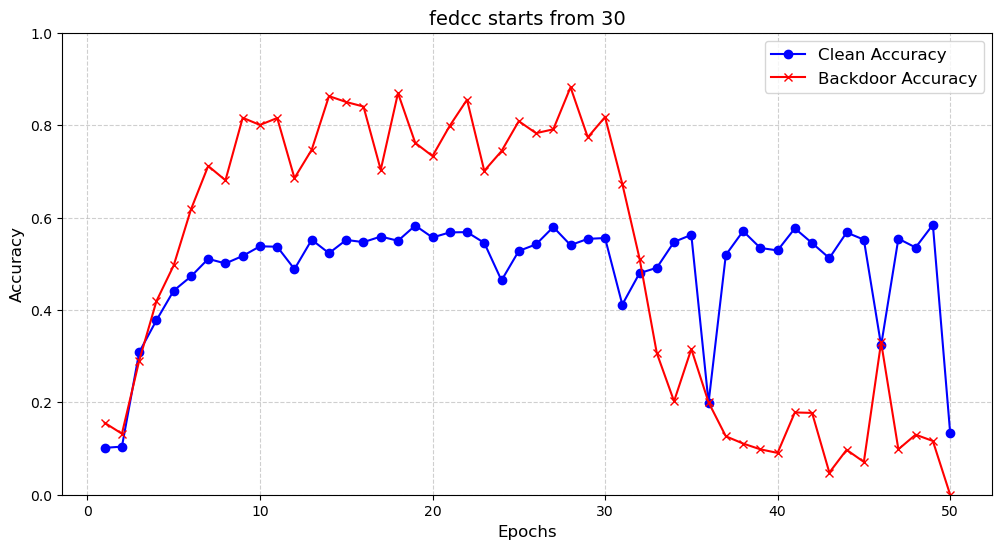

In [8]:
import matplotlib.pyplot as plt

epochs = list(range(1, epochs+1))  # 40 epochs

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, clean_acc_history, label='Clean Accuracy', marker='o', color='blue')
plt.plot(epochs, backdoor_acc_history, label='Backdoor Accuracy', marker='x', color='red')
plt.ylim(0, 1)

# Add title and labels
plt.title(f'{aggregation_rule} starts from {switch_epoch}', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend(fontsize=12)

# Display the plot
plt.show()


In [9]:

# # Data Preparation
# transform = transforms.Compose([transforms.ToTensor()])
#                                  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
# train_data = datasets.CIFAR10(root="../data/cifar10", train=True, transform=transform, download=True)
# test_data = datasets.CIFAR10(root="../data/cifar10", train=False, transform=transform, download=True)

# # Split data among clients
# client_data = create_dirichlet_noniid_data(train_data, num_clients, alpha)
# malicious_clients = random.sample(range(num_clients), num_malicious_clients)
# print(f"Malicious client idx {malicious_clients}")

# # DataLoader for test data
# clean_global_test_loader, backdoor_global_test_loader = create_test_datasets(test_data, backdoor_label, trigger_value)

# # Create clean and backdoor test datasets for each client
# local_test_datasets = []
# for client_idx in range(num_clients):
#     clean_test_loader, backdoor_test_loader = create_local_test_datasets(test_data, backdoor_label, trigger_value)
#     local_test_datasets.append((clean_test_loader, backdoor_test_loader))

# # Federated Training
# global_model = CNNCifar().to(device)
# criterion = nn.CrossEntropyLoss()
# for epoch in range(epochs):
#     print(f"\nEpoch {epoch + 1}/{epochs}")
#     local_weights = []
#     for client_idx, client_dataset in enumerate(client_data):
#         local_model = CNNCifar().to(device)  # Move local model to GPU
#         local_model.load_state_dict(global_model.state_dict())
        
#         # Set local epochs and learning rate
#         if client_idx in malicious_clients and epoch < 70:
#             local_epochs = 6
#             learning_rate = 0.05
#             optimizer = optim.SGD(local_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)
#             scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
#                                                  milestones=[0.2 * local_epochs,
#                                                              0.8 * local_epochs], gamma=0.1)
#         else:
#             local_epochs = 2
#             learning_rate = 0.1
#             optimizer = optim.SGD(local_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
                        
#         pos = 0

#         # Malicious clients inject backdoor samples
#         if client_idx in (malicious_clients) and epoch < 70:
#             x, y = zip(*client_dataset)
#             x = torch.stack(x).to(device)
#             y = torch.tensor(y).to(device)
#             data_loader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)
#             x_batches, y_batches = [], []
#             for x_batch, y_batch in data_loader:
#                 if len(x_batch) >= backdoor_samples_per_batch:
#                     x_batch, y_batch = inject_backdoor_samples(
#                         x_batch, y_batch, backdoor_samples_per_batch, backdoor_label, pos
#                     )
#                 x_batches.append(x_batch)
#                 y_batches.append(y_batch)
#             x = torch.cat(x_batches).to(device)
#             y = torch.cat(y_batches).to(device)
#             data_loader = DataLoader(list(zip(x, y)), batch_size=batch_size, shuffle=True)
#             pos = pos + 1
#         else:
#             data_loader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)

#         # Train the local model
#         local_model.train()
#         for local_epoch in range(local_epochs):
#             for x_batch, y_batch in data_loader:
#                 x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#                 optimizer.zero_grad()
#                 outputs = local_model(x_batch)
#                 loss = criterion(outputs, y_batch)
#                 loss.backward()
#                 optimizer.step()

#         # Save the local weights
#         local_weights.append({key: val.clone() for key, val in local_model.state_dict().items()})

#         # Evaluate the local model on its clean and backdoor test datasets
#         clean_test_loader, backdoor_test_loader = local_test_datasets[client_idx]
#         clean_accuracy = evaluate_model(local_model, clean_test_loader, device)
#         backdoor_accuracy = evaluate_model(local_model, backdoor_test_loader, device)

#         print(f"Client {client_idx} - Clean Accuracy: {clean_accuracy:.4f} | Backdoor Accuracy: {backdoor_accuracy:.4f}")

#     # Federated averaging
#     global_state_dict = global_model.state_dict()
#     for key in global_state_dict.keys():
#         # Scale the malicious clients' weights before averaging
#         scaled_weights = []
#         for i, local_weight in enumerate(local_weights):
#             if i in malicious_clients and epoch < 70:
#                 scaled_weights.append(scale_factor * local_weight[key])  # Scale malicious client weights
#             else:
#                 scaled_weights.append(local_weight[key])  # No scaling for benign clients
        
#         # Perform averaging of all client weights (scaled for malicious clients)
#         global_state_dict[key] = torch.mean(torch.stack(scaled_weights), dim=0)

#     # Load the updated global weights into the global model
#     global_model.load_state_dict(global_state_dict)

#     # Evaluate global model on clean and backdoor test datasets
#     clean_accuracy = evaluate_model(global_model, clean_global_test_loader, device)
#     backdoor_accuracy = evaluate_model(global_model, backdoor_global_test_loader, device)
#     print(f"Global Clean Accuracy: {clean_accuracy:.4f}")
#     print(f"Global Backdoor Accuracy: {backdoor_accuracy:.4f}")
